In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklift.models import (ClassTransformation,TwoModels   )
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklift.metrics import uplift_at_k, qini_auc_score,uplift_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklift.metrics import qini_curve
from sklift.metrics import uplift_curve


In [ ]:
rfm_df=pd.read_parquet('../csv_export/RFM.parquet')

In [ ]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223393 entries, 0 to 223392
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   CUSTOMER_ID                     223393 non-null  object 
 1   Recency                         223393 non-null  int64  
 2   Frequency                       223393 non-null  int64  
 3   Monetary                        223393 non-null  float64
 4   Total_Units                     223393 non-null  int64  
 5   Total_Organic_Discount          223393 non-null  float64
 6   Total_Extra_Discount            223393 non-null  float64
 7   Total_Discounts                 223393 non-null  float64
 8   AVG_ORGANIC_DISCOUNT_PER_ORDER  223393 non-null  float64
 9   USED_ORGANIC_DISCOUNT_RATIO     223393 non-null  float64
 10  AVG_EXTRA_DISCOUNT_PER_ORDER    223393 non-null  float64
 11  USED_EXTRA_DISCOUNT_RATIO       223393 non-null  float64
 12  AVG_TOTAL_DISCOU

In [ ]:
rfm_df.dropna(inplace=True)

## Churn Label


In [ ]:
categorical_cols = [
    'FAVOURITE_STORE',
    'FAVOURITE_STORE_TYPE',
    'FAVOURITE_PAYMENT_METHOD',
    'FAVORITE_CATEGORY',
    'FAVORITE_SUB_CATEGORY',
    'FAVORITE_WEEKDAY'
]

numerical_cols = [
    col for col in rfm_df.select_dtypes(include=['int64', 'float64']).columns
    if col != 'CUSTOMER_ID' and col != 'FAVORITE_HOUR'  
]

categorical_cols.append('FAVORITE_HOUR')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(rfm_df)

num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = list(num_features) + list(cat_features)

X_df = pd.DataFrame(X_processed, columns=all_features, index=rfm_df.index) # type: ignore


## IsolationForest


In [ ]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)  
rfm_df['Anomaly_Score'] = iso_forest.fit_predict(X_df)

rfm_df['Churn_Label_IsoForest'] = (rfm_df['Anomaly_Score'] == -1).astype(int)

## LocalOutlierFactor


In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
rfm_df['LOF_Score'] = lof.fit_predict(X_df)

rfm_df['Churn_Label_LOF'] = (rfm_df['LOF_Score'] == -1).astype(int)

## OneClassSVM


In [ ]:
oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')  
oc_svm.fit(X_df)

labels_ocsvm = oc_svm.predict(X_df)  
rfm_df['Churn_Label_OCSVM'] = (labels_ocsvm == -1).astype(int)

## Treatment


In [ ]:
rfm_df['Treatment'] = (rfm_df['USED_EXTRA_DISCOUNT_RATIO'] > 0.05).astype(bool)

## Modelling


In [ ]:
models = {
    "TwoModels_XGB_vs_RF": TwoModels(
        estimator_trmnt=XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6, eval_metric='logloss', random_state=42),
        estimator_ctrl=RandomForestClassifier(n_estimators=1000, random_state=42),
        method='vanilla'
    ),
      'tm_logreg_svm': TwoModels(
        estimator_trmnt=LogisticRegression(max_iter=1000),
        estimator_ctrl=SVC(probability=True),
        method='vanilla'
    ),
      'ct_xgb': ClassTransformation(
        estimator=XGBClassifier( eval_metric='logloss')
    ),
    'ct_rf': ClassTransformation(
        estimator=RandomForestClassifier(n_estimators=1000, random_state=42),
    ),
}


## Evaluation


## Isolation Forest Label + Uplift Model


In [ ]:
yLabel_IsoForest = rfm_df.loc[X_df.index, 'Churn_Label_IsoForest']
treatment = rfm_df.loc[X_df.index, 'Treatment'].astype(int)

X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_IsoForest, treatment, test_size=0.3, stratify=treatment, random_state=42
)

In [ ]:
results = {}
best_score = -1
best_model = None

In [ ]:
print("\n Isolation Forest Label + Uplift Model...")

for name, model in models.items():
    print(f"\n {name}...")

    model.fit(X_train, y_train, treat_train)
    preds = model.predict(X_test)
    
    qini_score = qini_auc_score(y_test, preds, treat_test)
    auuc_score = uplift_auc_score(y_test, preds, treat_test)
    results[name] = {
        "uplift": preds,
        "qini_auc": qini_score,
         "auuc": auuc_score  
    }
    print(f"\n Qini AUC: {qini_score:.4f} \n AUUC: {auuc_score:.4f} ")
    if qini_score > best_score:
        best_score = qini_score
        best_model = model


 TwoModels_XGB_vs_RF...

 Qini AUC: 0.5479 
 AUUC: 0.3153 

 tm_logreg_svm...

 Qini AUC: 0.4576 
 AUUC: 0.1484 

 ct_xgb...

 Qini AUC: 0.3598 
 AUUC: 0.5000 

 ct_rf...

 Qini AUC: 0.3461 
 AUUC: 0.4011 


## Local Outlier Factor Label + Uplift Model


In [ ]:
yLabel_LOF = rfm_df.loc[X_df.index, 'Churn_Label_LOF']
treatment = rfm_df.loc[X_df.index, 'Treatment'].astype(int)

X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_LOF, treatment, test_size=0.3, stratify=treatment, random_state=42
)

In [ ]:
print("\n Local Outlier Factor Label + Uplift Model...")

for name, model in models.items():
    print(f"\n {name}...")

    model.fit(X_train, y_train, treat_train)
    preds = model.predict(X_test)
    
    qini_score = qini_auc_score(y_test, preds, treat_test)
    auuc_score = uplift_auc_score(y_test, preds, treat_test)
    results[name] = {
        "uplift": preds,
        "qini_auc": qini_score,
         "auuc": auuc_score,
    }
    print(f"\n Qini AUC: {qini_score:.4f} \n AUUC: {auuc_score:.4f} ")
    if qini_score > best_score:
        best_score = qini_score
        best_model = model


 TwoModels_XGB_vs_RF...

 Qini AUC: 0.4405 
 AUUC: 0.2299 

 tm_logreg_svm...

 Qini AUC: -0.2838 
 AUUC: -0.0463 

 ct_xgb...

 Qini AUC: 0.2001 
 AUUC: 0.3465 

 ct_rf...

 Qini AUC: 0.2410 
 AUUC: 0.5332 


## One-Class SVM Label + Uplift Model


In [ ]:
yLabel_OCSVM = rfm_df.loc[X_df.index, 'Churn_Label_OCSVM']
treatment = rfm_df.loc[X_df.index, 'Treatment'].astype(int)

X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_OCSVM, treatment, test_size=0.3, stratify=treatment, random_state=42
)

In [ ]:
print("\n One-Class SVM Label + Uplift Model...")

for name, model in models.items():
    print(f"\n {name}...")

    model.fit(X_train, y_train, treat_train)
    preds = model.predict(X_test)
    
    qini_score = qini_auc_score(y_test, preds, treat_test)
    auuc_score = uplift_auc_score(y_test, preds, treat_test)
    upliftk=uplift_at_k(y_test, preds, treat_test,'by_group',k=0.05)
    results[name] = {
        "uplift": preds,
        "qini_auc": qini_score,
         "auuc": auuc_score
    }
    print(f"\n Qini AUC: {qini_score:.4f} \n AUUC: {auuc_score:.4f} ")
    if qini_score > best_score:
        best_score = qini_score
        best_model = model


 TwoModels_XGB_vs_RF...

 Qini AUC: 0.6018 
 AUUC: 0.4273 

 tm_logreg_svm...

 Qini AUC: 0.1759 
 AUUC: 0.0564 

 ct_xgb...

 Qini AUC: 0.4571 
 AUUC: 0.5309 

 ct_rf...

 Qini AUC: 0.3520 
 AUUC: 0.5330 


## Qini Curve


In [ ]:
yLabel_OCSVM = rfm_df.loc[X_df.index, 'Churn_Label_OCSVM']
treatment = rfm_df.loc[X_df.index, 'Treatment'].astype(int)

X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_OCSVM, treatment, test_size=0.3, stratify=treatment, random_state=42
)
m=models['TwoModels_XGB_vs_RF'].fit(X_train, y_train, treat_train)
preds = m.predict(X_test)

x_qini, y_qini = qini_curve(y_true=y_test, uplift=preds, treatment=treat_test)

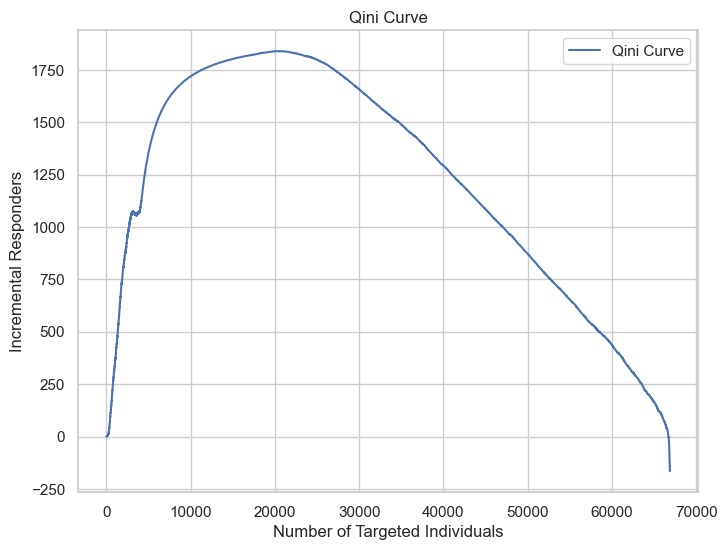

In [ ]:
print ("Quini Curve Data:")

plt.figure(figsize=(8, 6))
plt.plot(x_qini, y_qini, label='Qini Curve')
plt.xlabel('Number of Targeted Individuals')
plt.ylabel('Incremental Responders')
plt.title('Qini Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x_uplift, y_uplift = uplift_curve(y_true=y_test, uplift=preds, treatment=treat_test)

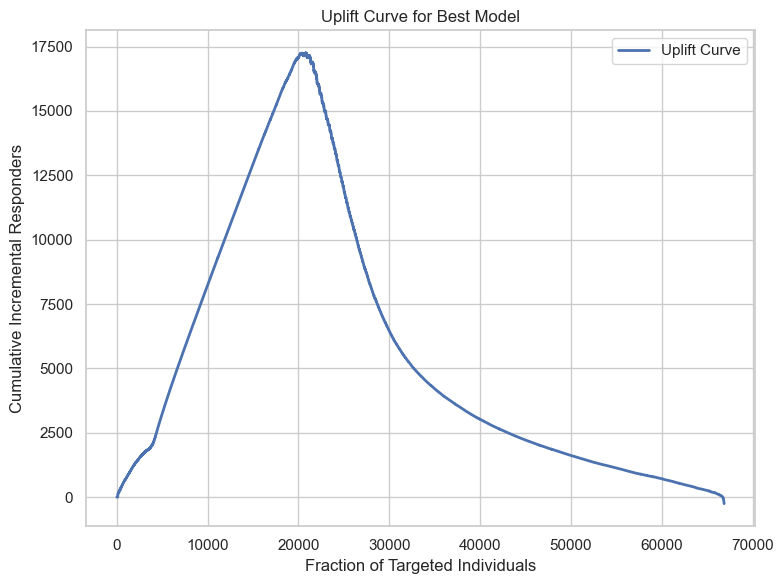

In [ ]:
print ("Uplift Curve Data:")

plt.figure(figsize=(8, 6))
plt.plot(x_uplift, y_uplift, label=f'Uplift Curve', linewidth=2)
plt.xlabel('Fraction of Targeted Individuals')
plt.ylabel('Cumulative Incremental Responders')
plt.title(f'Uplift Curve for Best Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

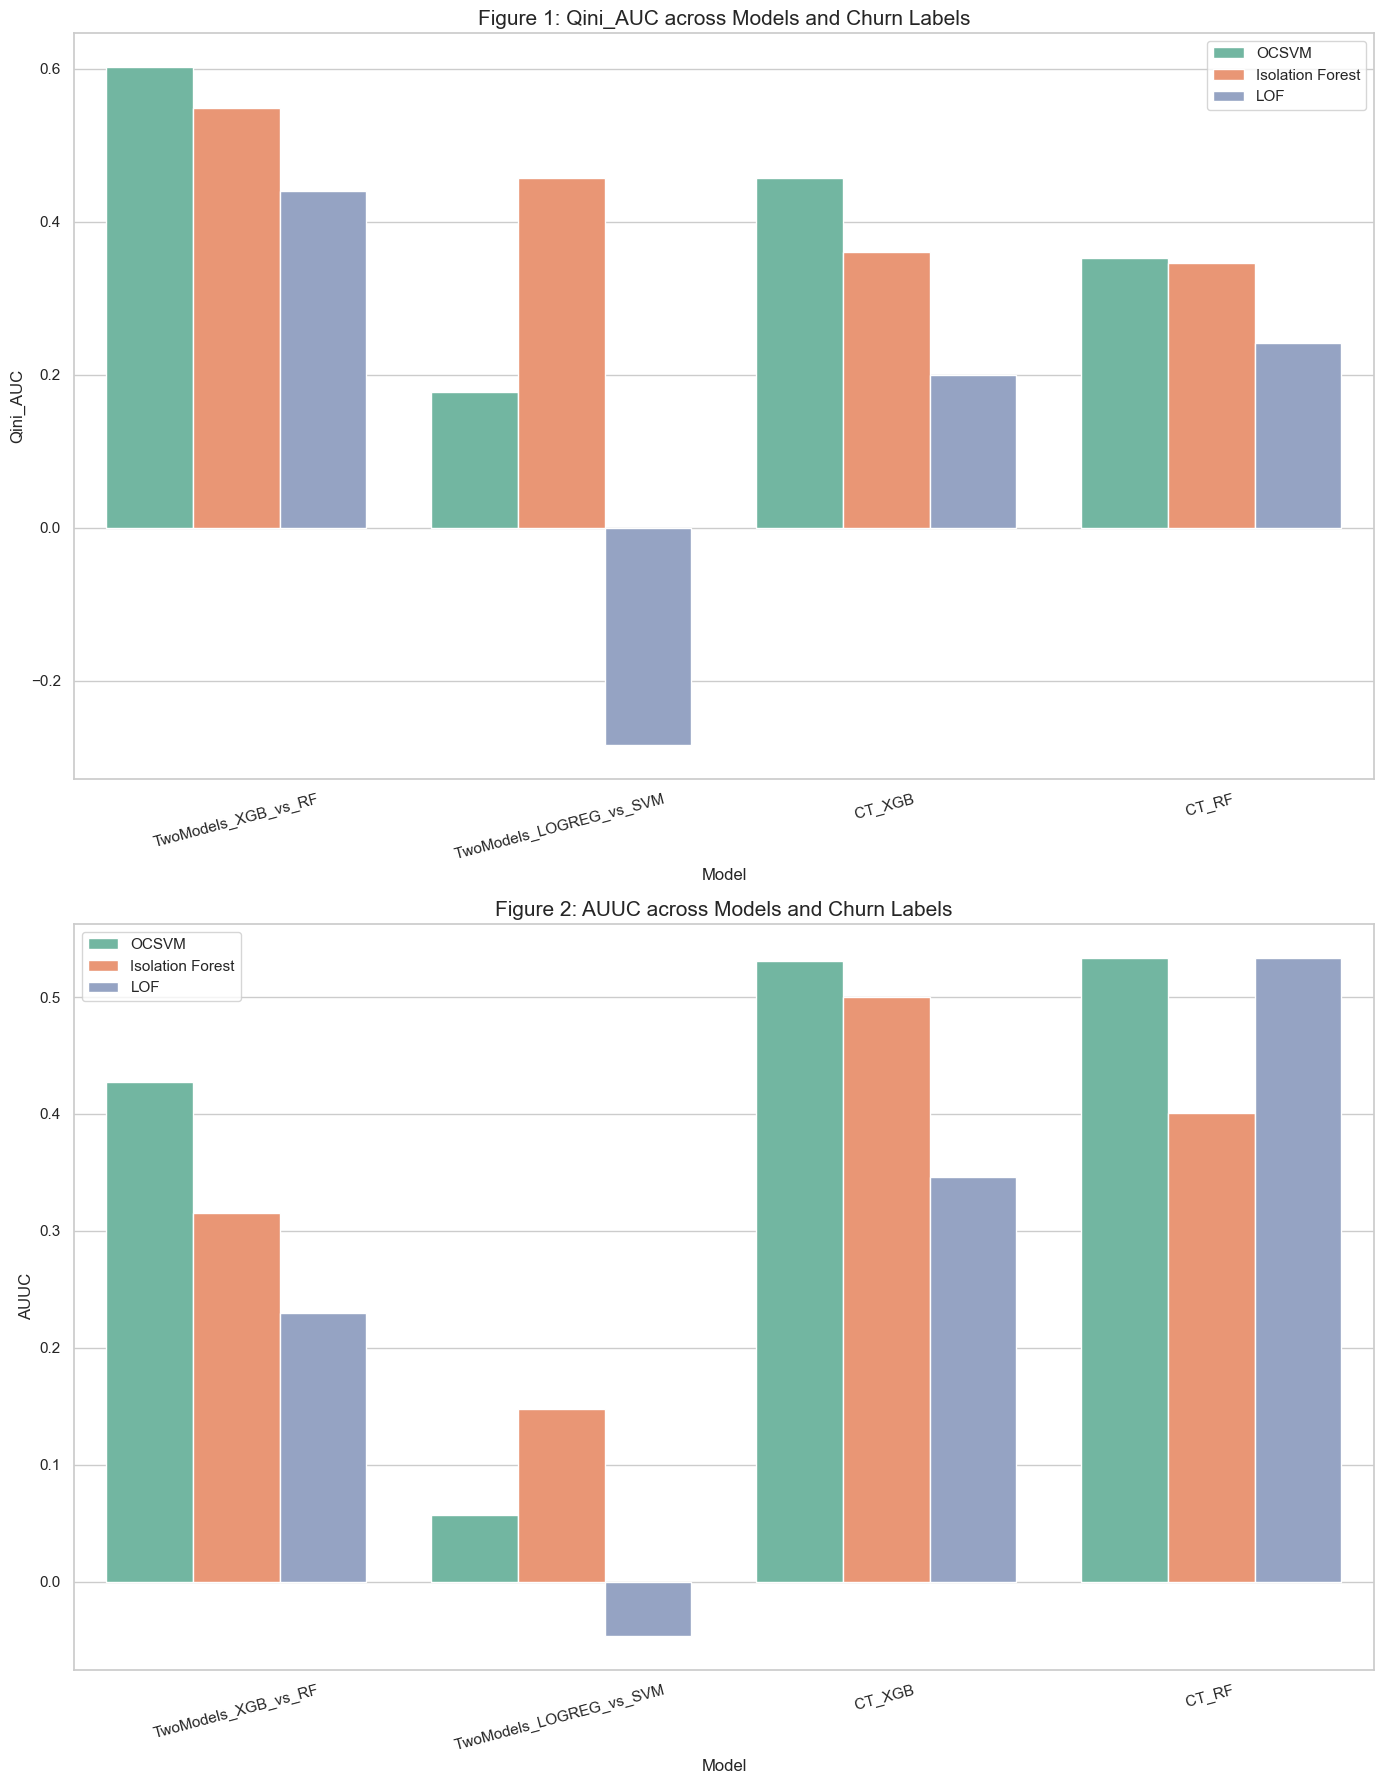

In [ ]:
print("Bar Comparison of Qini AUC and AUUC across Models and Churn Labels")

data = {
    "Model": [
        "TwoModels_XGB_vs_RF", "TwoModels_LOGREG_vs_SVM ", "CT_XGB ", "CT_RF ",
        "TwoModels_XGB_vs_RF", "TwoModels_LOGREG_vs_SVM ", "CT_XGB ", "CT_RF ",
        "TwoModels_XGB_vs_RF", "TwoModels_LOGREG_vs_SVM ", "CT_XGB ", "CT_RF "
    ],
    "Churn_Label": [
        "OCSVM", "OCSVM", "OCSVM", "OCSVM",
        "Isolation Forest", "Isolation Forest", "Isolation Forest", "Isolation Forest",
        "LOF", "LOF", "LOF", "LOF"
    ],
    "Qini_AUC": [
        0.6018, 0.1768, 0.4571, 0.3520,
        0.5479, 0.4575, 0.3598, 0.3461,
        0.4405, -0.2836, 0.2001, 0.2410
    ],
    "AUUC": [
        0.4273, 0.0568, 0.5309, 0.5330,
        0.3153, 0.1481, 0.5000, 0.4011,
        0.2299, -0.0461, 0.3465, 0.5332
    ]
}

df = pd.DataFrame(data)

fig, axes = plt.subplots(2, 1, figsize=(14, 18))
metrics = ['Qini_AUC', 'AUUC']


for i, metric in enumerate(metrics):
    sns.barplot(data=df, x='Model', y=metric, hue='Churn_Label', ax=axes[i], palette='Set2')
    axes[i].set_title(f'Figure {i+1}: {metric} across Models and Churn Labels', fontsize=15)
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=15)
    axes[i].legend()

plt.tight_layout()
plt.show()


## Targets Dataset


In [ ]:
rfm_df.loc[X_test.index, 'Uplift_Score'] = preds

In [ ]:
churned_customers = rfm_df[rfm_df['Churn_Label_OCSVM'] == 1]

top_churned_customers = churned_customers.sort_values('Uplift_Score', ascending=False).head(10000).copy()

In [191]:
def assign_discount(uplift):
    if uplift > 0.5:        
        return 0.25
    elif uplift > 0.3:      
        return 0.15
    elif uplift > 0.15:     
        return 0.05
    else:
        return 0.00          


In [ ]:
top_churned_customers['Assigned_Discount'] = top_churned_customers['Uplift_Score'].apply(assign_discount)

In [ ]:
top_churned_customers['Assigned_Discount'] = top_churned_customers['Uplift_Score'].apply(assign_discount)
top_churned_customers['Expected_Revenue_Saved'] = top_churned_customers['Monetary'] * top_churned_customers['Uplift_Score']
top_churned_customers['Discount_Cost'] = top_churned_customers['Monetary'] * top_churned_customers['Assigned_Discount']
top_churned_customers['ROI'] = top_churned_customers['Expected_Revenue_Saved'] / top_churned_customers['Discount_Cost'].replace(0, 1)

In [ ]:
top_churned_customers['Uplift_Decile'] = pd.qcut(top_churned_customers['Uplift_Score'], 10, labels=False)

In [ ]:
print("\nTop 10 Churned Customers with Assigned Discounts and ROI:")
print(top_churned_customers.head(10))

,CUSTOMER_ID,Recency,Frequency,Monetary,Total_Units,Total_Organic_Discount,Total_Extra_Discount,Total_Discounts,AVG_ORGANIC_DISCOUNT_PER_ORDER,USED_ORGANIC_DISCOUNT_RATIO,...,FAVORITE_WEEKDAY,FAVORITE_HOUR,Churn_Label_OCSVM,Treatment,Uplift_Score,Assigned_Discount,Expected_Revenue_Saved,Discount_Cost,ROI,Uplift_Decile
45705,34d981afb6646e7b832ce90113798b69ec0e16b60784b9...,502,1,27.5000,1,7.20,0.0000,7.2000,7.200000,1.00000,...,Wednesday,18,1,False,0.956316,0.25,26.298677,6.87500,3.825262,9.0
30081,22ebb56cc52adb05d8130d12dad9ef8f75c9ccdf97a52c...,142,1,47.6782,1,7.51,0.0118,7.5218,7.510000,1.00000,...,Saturday,0,1,True,0.951540,0.25,45.367713,11.91955,3.806160,9.0
74107,551561bbcd61010315d7dfa565cffc7ff666ebf8626a91...,156,1,54.6882,1,6.49,0.0118,6.5018,6.490000,1.00000,...,Saturday,23,1,True,0.943970,0.25,51.624029,13.67205,3.775881,9.0
36765,2a929c8db43150d44af9e4666de2d5180e3cf47b405e29...,99,1,47.7882,1,7.50,0.0118,7.5118,7.500000,1.00000,...,Sunday,0,1,True,0.941290,0.25,44.982537,11.94705,3.765159,9.0
126231,903afffa75d18516799cbd38d6b470eee395b371026350...,187,1,37.5782,1,7.31,0.0118,7.3218,7.310000,1.00000,...,Wednesday,12,1,True,0.932445,0.25,35.039591,9.39455,3.729779,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188848,d7f9a82423984e75e664167491af16c26ecd221a44a4ea...,229,3,352.2000,3,132.00,0.0000,132.0000,44.000000,1.00000,...,Tuesday,19,1,False,NaN,0.00,NaN,0.00000,NaN,NaN
188887,d806c0e92d7d7985628855d4548f1c04c3395966474376...,547,61,2796.0100,91,46.00,646.3900,692.3900,0.754098,0.04918,...,Sunday,20,1,True,NaN,0.00,NaN,0.00000,NaN,NaN
188954,d81a959edfb697abd10df381f8bf34e3a45ef131ad16ef...,11,96,13262.6900,182,2000.95,0.3000,2001.2500,20.843229,1.00000,...,Saturday,18,1,False,NaN,0.00,NaN,0.00000,NaN,NaN
188973,d81f5d45c27704b06d87026d147abe319d3cd65159f76f...,18,124,8829.2312,219,1134.72,856.6188,1991.3388,9.150968,0.75000,...,Sunday,20,1,True,NaN,0.00,NaN,0.00000,NaN,NaN


In [ ]:
print("Targeted Group Summary:")
print("Mean ROI:", round(top_churned_customers['ROI'].mean(), 2))
print("ROI > 1 Count:", (top_churned_customers['ROI'] > 1).mean()*100)
print("Total Expected Revenue Saved:", round(top_churned_customers['Expected_Revenue_Saved'].sum(), 2))
print("Total Discount Cost:", round(top_churned_customers['Discount_Cost'].sum(), 2))

Targeted Group Summary:
Mean ROI: 41.46
ROI > 1 Count: 27.250000000000004
Total Expected Revenue Saved: 1348896.72
Total Discount Cost: 377725.93
